In [83]:
import numpy as np
import pandas as pd
import datetime
import glob
import os
 
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import matplotlib.dates 
from matplotlib.ticker import MultipleLocator, FuncFormatter, NullFormatter
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

# Import data 

In [84]:
path = os.path.abspath(os.path.join( os.getcwd()   , 'log_files\\') ) 

log_files = glob.glob( path+ '*.csv')  

df = pd.DataFrame()
for file in log_files :
    df_temp = pd.read_csv( file, index_col=None, header=0)  
    df = df.append(df_temp ,sort=False)   
    
df.tail()

,date,start time,Task,Label,Duration (s)
125,2020/04/16,19:52:31,NaN,Other,2
126,2020/04/16,19:52:41,NaN,Other,3
127,2020/04/16,19:52:45,NaN,Other,2
128,2020/04/16,19:52:47,NaN,Other,2
129,2020/04/16,19:52:50,NaN,Other,2


# Data processing 


In [85]:
# remove any task shorter than 1 minute, it's probably a test
bool_short_duration = df['Duration (s)'] < 60
df = df[~bool_short_duration]


# standardize labels 
change_labels = ['Timing feedforward','Timing feedforward project','FFtiming pend','Timing feedforw']
goal_label = 'FF timing pend'
for change_label in change_labels:
    bool_label = df['Label'] != change_label 
    df['Label'] = df['Label'].where(bool_label, goal_label ) 
    
    
change_labels = ['Code','Study']
goal_label = 'Coding study'
for change_label in change_labels:
    bool_label = df['Label'] != change_label 
    df['Label'] = df['Label'].where(bool_label, goal_label ) 
    
    
    
change_labels = ['Jobsearch']
goal_label = 'Job search'
for change_label in change_labels:
    bool_label = df['Label'] != change_label 
    df['Label'] = df['Label'].where(bool_label, goal_label ) 
    
    
    
df['Label'].unique()

array(['Other', 'Meetings', 'Coding study', 'Job search', 'FEA project',
       'News', 'FF timing pend', 'Flex pendulum'], dtype=object)

 # Data conversion

In [86]:
df['date'] = pd.to_datetime(df['date'] )  
df['Duration (hh:mm:ss)'] = pd.to_timedelta(df['Duration (s)'],'s')
df.tail()
df['Week'] = df['date'].dt.strftime("%V")

In [87]:
df_week = df.groupby(['Week','Label',]).sum()
df_week['Time spent per week'] = pd.to_timedelta(df_week['Duration (s)'],'s')
df_week =df_week.drop( ['Duration (s)'],axis=1)  

# df_week.tail(10)

In [88]:
df_day = df.groupby(['date','Label',]).sum()
df_day['Time spent per day'] = pd.to_timedelta(df_day['Duration (s)'],'s')
df_day =df_day.drop( ['Duration (s)'],axis=1) 
df_day.tail(10)

Time spent per day
date       Label                            
2020-04-14 FF timing pend           01:49:25
           News                     01:05:52
2020-04-15 Coding study             03:43:43
           Flex pendulum            01:24:58
           News                     02:03:49
           Other                    00:06:56
2020-04-16 Flex pendulum            04:39:40
           Job search               00:21:57
           News                     01:04:58
           Other                    01:21:42

In [89]:
bool_work = df['Label'].isin(['FF timing pend','Flex pendulum','FEA wing','Lab business'])
 
df_temp = df[bool_work].groupby('date').sum()
df_temp['Worked per day'] = pd.to_timedelta( df_temp['Duration (s)'] ,'s')  
df_temp = df_temp.drop( ['Duration (s)'],axis=1) 
df_temp.tail()

,Worked per day
date,
2020-04-13,03:33:39
2020-04-14,01:49:25
2020-04-15,01:24:58
2020-04-16,04:39:40


 # Set plotting color

In [90]:
# make colorscheme 
cols = np.array([[166,206,227], 
[31,120,180], 
[178,223,138], 
[51,160,44], 
[251,154,153], 
[227,26,28], 
[253,191,111], 
[255,127,0], 
[202,178,214], 
[106,61,154], 
[255,255,153]]) /255  

labels = df['Label'].unique()     
label_dict = {}
for label,col in zip(labels,cols): 
    label_dict[label] = col 

# Create plotting functions 

In [91]:
def get_sec(time_str):
    """Get Seconds from time."""
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

def tick(x,pos): 
    days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    return days[int(x)]  
    
def hours_to_hhmm( arr ): 
    out_list = []
    for val in arr:
        if val< 10:
            test = '0' + str(val) +':00'
        else:
            test = str(val) + ':00'
        out_list.append(test)
    return( out_list ) 
 
def plot_week_tasks( ax_pl, df_week, label_dict, bool_legend=False ):
    days_in_week = df_week['date'].unique()
    for day in days_in_week : 
        bool_day = df_week['date'] == day 
        df_week_temp = df_week[bool_day] 

        for j,row in df_week_temp.iterrows():
            y = get_sec( row['start time'] )
            dy =  row['Duration (s)'] 
            label = row['Label']  
            ax_pl.bar( row['date'],dy, bottom = y, 
                      color = label_dict[label] , label = label ) 
 
    # set xlim 
    first_day = pd.to_datetime( days_in_week[0] )
    mon_day = first_day - datetime.timedelta( first_day.isocalendar()[2] -0.5 )
    sun_day = mon_day + datetime.timedelta( 7)    
#     ax_pl.set_xlim([mon_day,sun_day]) 
    ax_pl.set_xlim( matplotlib.dates.date2num(mon_day)-0.2, matplotlib.dates.date2num(sun_day)+0.2 )

    # set ylim 
    ax_pl.set_ylim([6*3600,19*3600]) 

    # set xaxis ticks and ticklabels
    ax_pl.xaxis.set_major_locator(MultipleLocator(1))
    daysFmt = DateFormatter("%a")
    ax_pl.xaxis.set_major_formatter(daysFmt) 
    for tick in ax_pl.get_xticklabels():
        tick.set_rotation( 45 )
        
    # set yaxis ticks 
    ax_pl.invert_yaxis()
    hours = np.array([9,12,13,17])
    ax_pl.yaxis.set_ticks( hours*3600)
    ax_pl.yaxis.set_ticklabels( hours_to_hhmm(hours ) )
    ax_pl.yaxis.grid('on')
 
    # remove spines 
    ax_pl.spines['top'].set_visible(False)
    ax_pl.spines['right'].set_visible(False) 
    
    # set background transparent for when graphs overlap slightly 
    ax_pl.patch.set_visible(False)
    
    # set legend 
    if bool_legend:
        handles, labels = ax_pl.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax_pl.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5) )
    
    bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5) 
    ax_pl.annotate( mon_day.date(), (mon_day,7*3600), 
                   va='top',ha='left' ,
                   bbox={'boxstyle':"round,pad=0.1", 'fc':"w",'ec':'w', 'alpha':0.9})
    
    
def plot_time_spent_weekly(ax_pl,df_pl, label_dict, bool_legend=False):
    #[0,1] plot overview of total time 
    df_pl = df_week.groupby('Label').sum() 
    df_pl.index

    col_list = []
    for key in df_pl.index.tolist():
        col_list.append( label_dict[key] ) 

    ax_pl.barh( df_pl.index, df_pl['Duration (s)'],color=col_list )

    hours = np.array([0,2,4,6,8,10])
    ax_pl.xaxis.set_ticks( hours*3600)
    ax_pl.xaxis.set_ticklabels( hours_to_hhmm(hours ) )
    ax_pl.set_xlabel('Total time spent (hh:mm)') 

    # remove spines 
    ax_pl.spines['top'].set_visible(False)
    ax_pl.spines['right'].set_visible(False) 
    
    # put grid on major x-ticks
    ax_pl.xaxis.grid('on')
    
    # set background transparent for when graphs overlap slightly 
    ax_pl.patch.set_visible(False)
    
    # set legend 
    if bool_legend:
        handles, labels = ax_pl.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax_pl.legend(by_label.values(), 
                     by_label.keys(), 
                     loc='center left', 
                     bbox_to_anchor=(1, 0.5) )





    
def plot_time_spent_daily( ax_pl, df_week, label_dict, bool_legend=False): 
    
    # sum per date and labels
    df_pl = df_week.groupby(['date','Label']).sum().reset_index() 

    # obtain labels sorted by duration 
    df_pl = df_pl.sort_values( by=['date','Duration (s)'], ascending=False)
    labels = df_pl['Label'].unique()
    
    # set bar with  
    bar_w = 1/len(labels)  
 
    days_in_week = df_pl['date'].unique()
    
    for day in days_in_week:
        bool_day = df_pl['date'] == day 

        # find labels per day
        day_labels =  df_pl.loc[bool_day,'Label'].unique()  
        n_day = len(day_labels) 
        
        for i,label in enumerate(day_labels): 
            bool_label = df_pl['Label'] == label

            # center bars around date
            x =  matplotlib.dates.date2num(day)+ i*bar_w - n_day*bar_w/2   
            y = df_pl.loc[bool_day & bool_label,'Duration (s)'].iloc[0]  
            
            # plot individual bars 
            ax_pl.bar(x,y, width = bar_w,
                   align='edge',
                   color=label_dict[label],
                     label = label )

    # # set xlim 
    first_day = pd.to_datetime( days_in_week[0] )
    mon_day = first_day - datetime.timedelta( first_day.isocalendar()[2] -0.5 )
    sun_day = mon_day + datetime.timedelta( 7)    
#     ax_pl.set_xlim([mon_day,sun_day])  
    ax_pl.set_xlim( matplotlib.dates.date2num(mon_day)-0.2, matplotlib.dates.date2num(sun_day)+0.2 )

    # # set xaxis ticks and ticklabels
    ax_pl.xaxis.set_major_locator(MultipleLocator(1))
    daysFmt = DateFormatter("%a")
    ax_pl.xaxis.set_major_formatter(daysFmt) 
    for tick in ax_pl.get_xticklabels():
        tick.set_rotation( 45 )

    # # set yaxis ticks  
    hours = np.array([0,1,2,3,4 ])
    ax_pl.yaxis.set_ticks( hours*3600)
    ax_pl.yaxis.set_ticklabels( hours_to_hhmm(hours ) )
    ax_pl.yaxis.grid('on')

    # remove spines 
    ax_pl.spines['top'].set_visible(False)
    ax_pl.spines['right'].set_visible(False) 

    # set background transparent for when graphs overlap slightly 
    ax_pl.patch.set_visible(False)
    
    # set axis label 
    ax_pl.set_ylabel('Time spent per day (hh:mm)')

    # set legend 
    if bool_legend:
        handles, labels = ax_pl.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax_pl.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5) )

    bbox_props = dict(boxstyle="round,pad=0.1", fc="w", ec="w", lw=2, alpha = 0.5) 
    ax_pl.annotate( mon_day.date(), (mon_day,7*3600), 
                   va='top',ha='left' ,
                   bbox={'boxstyle':"round,pad=0.1", 'fc':"w",'ec':'w', 'alpha':0.9})


# Plot tracked time per week

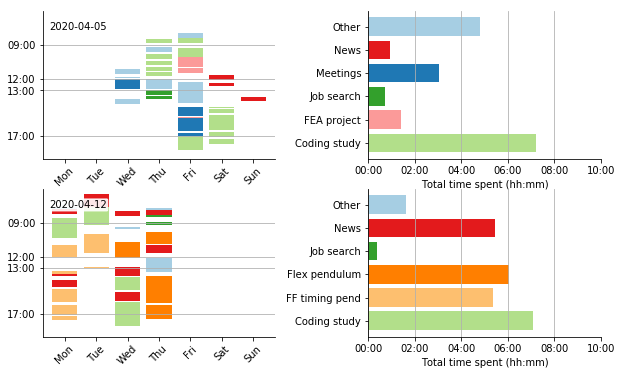

In [92]:
weeks = df['Week'].unique()
weeks = weeks[2:]

fig, ax= plt.subplots( len(weeks), 2, figsize =(10,6))
# ax = ax.flat # flatten so iteration is simpler

for i, week in enumerate(weeks):  
    bool_week = df['Week'] == week
    df_week = df[bool_week].copy() 
    
    # plot left axis
    plot_week_tasks( ax[i,0], df_week, label_dict )
    plot_time_spent_weekly( ax[i,1], df_week, label_dict )
      
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.4, hspace=None)

# Plot this week 

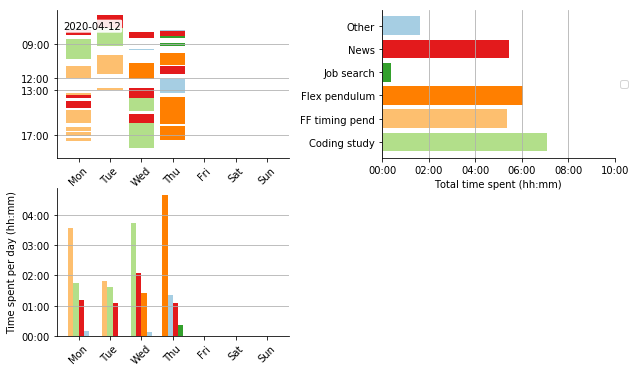

In [93]:
bool_week = df['Week'] == weeks[-1]
df_week = df[bool_week].copy() 

fig, ax = plt.subplots(2, 2, squeeze=False, figsize =(10,6))

# plot 3 subplots
plot_week_tasks( ax[0,0], df_week, label_dict ) 
plot_time_spent_weekly(ax[0,1], df_week, label_dict, bool_legend=True)
plot_time_spent_daily( ax[1,0], df_week, label_dict ,bool_legend=False) 
  
# adjust layout 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.4, hspace=None) 

# remove unused lower right axes object 
ax[1,1].axes.remove()